useful links:

- Data Preparation for Variable Length Input Sequences, URL: https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/
- Masking and padding with Keras, URL: https://www.tensorflow.org/guide/keras/masking_and_padding
- Step-by-step understanding LSTM Autoencoder layers, URL: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352XX, 
- Understanding input_shape parameter in LSTM with Keras, URL: https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
- tf.convert_to_tensor, URL: https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
- ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int) in Python, URL: https://datascience.stackexchange.com/questions/82440/valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupported-object-type

In [1]:
"""
* Copyright 2020, Maestria de Humanidades Digitales,
* Universidad de Los Andes
*
* Developed for the Msc graduation project in Digital Humanities
*
* This program is free software: you can redistribute it and/or modify
* it under the terms of the GNU General Public License as published by
* the Free Software Foundation, either version 3 of the License, or
* (at your option) any later version.
*
* This program is distributed in the hope that it will be useful,
* but WITHOUT ANY WARRANTY; without even the implied warranty of
* MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
* GNU General Public License for more details.
*
* You should have received a copy of the GNU General Public License
* along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

# ===============================
# native python libraries
# ===============================
import re
import random
import json
import csv
import cv2
import datetime
import copy
import gc
from collections import OrderedDict
from collections import Counter
from collections import deque

# ===============================
# extension python libraries
# ===============================
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt

# natural language processing packages
import gensim
from gensim import models
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# downloading nlkt data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# sample handling sklearn package
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain

# # Keras + Tensorflow ML libraries
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from keras.optimizers import SGD

# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# ===============================
# developed python libraries
# ===============================

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.

taken from https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
'''
def temporalize(data, lookback):
    output_X = list()
    for i in range(len(X)-lookback-1):
        temp = list()
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            temp.append(data[[(i+j+1)], :])
        temp = np.array(temp, dtype="object")
        output_X.append(temp)
    output_X = np.array(output_X, dtype="object")
    return output_X

In [3]:
def read_img(img_fpn):
    ans = cv2.imread(img_fpn, cv2.IMREAD_UNCHANGED)
    return ans

In [4]:
def std_img(img, minv, maxv):
    rangev = maxv - minv
    ans = img.astype("float32")/float(rangev)
    # ans = pd.Series(ans)
    # respuesta de la funcion
    return ans

In [5]:
def pad_img(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(np.uint16) # floor
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(np.uint16)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(np.uint16)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(np.uint16) # floor
    # print((top_pad, bottom_pad), (left_pad, right_pad))
    ans = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode="constant", constant_values=0)
    return ans

In [6]:
def get_images(rootf, src_df, src_col, tgt_col):
    ans = src_df
    src_files = list(ans[src_col])
    tgt_files = list()

    # ansdict = {}
    for tfile in src_files:
        tfpn = os.path.join(rootf, tfile)
        # print(tfpn)
        # print(os.path.exists(tfpn))
        timg = read_img(tfpn)
        tgt_files.append(timg)

    ans[tgt_col] = tgt_files
    return ans

In [7]:
def augment_images(src_df, tgt_col, syth_num):

    cols = [list(src_df.columns.values)]
    # print(cols)
    ans = pd.DataFrame()
    other_cols = list(src_df.columns.values)
    other_cols.remove(tgt_col)
    # print(other_cols)

    for index, row in src_df.iterrows():
        t_img = row[tgt_col]
        t_tags = row[other_cols]

        gen_rows = list()
        for i in range(syth_num):

            gen_tags = copy.deepcopy(t_tags)
            gen_img = syth_img(t_img)
            # print(type(gen_tags), type(gen_img)) 
            gen_tags[tgt_col] = gen_img
            gen_rows.append(gen_tags)
            # print(gen_tags) # , type(gen_img)) 
            # [other_cols], row[tgt_col])
        
        ans = ans.append(gen_rows, ignore_index=True)

    return ans

In [8]:
def syth_img(data):

    samples = expand_dims(data, 0)
    datagen = ImageDataGenerator(rotation_range=90)
    ans = datagen.flow(samples, batch_size=1)
    ans = ans[0].astype("uint8")
    ans = np.squeeze(ans, 0)
    return ans

In [9]:
def padding_images(src_df, src_col, tgt_col, max_shape):
    ans = src_df
    src_images = ans[src_col]
    tgt_images = list()
    max_x, max_y = max_shape[0], max_shape[1]
    padding = None

    # ansdict = {}
    for timg in src_images:
        # print(timg)
        timg = np.asarray(timg, dtype="object")
        # std_timg = std_img(timg, 0, 255)
        pimg = pad_img(timg, max_y, max_x)
        tgt_images.append(pimg)

    ans[tgt_col] = tgt_images
    return ans

In [10]:
def standarize_images(src_df, src_col, tgt_col):
    ans = src_df
    src_images = ans[src_col]
    tgt_images = list()

    # ansdict = {}
    for timg in src_images:
        # print(timg)
        timg = np.asarray(timg, dtype="object")
        std_timg = std_img(timg, 0, 255)
        tgt_images.append(std_timg)

    ans[tgt_col] = tgt_images
    return ans

In [11]:
# function to get the max shape in the image dataset
def get_mshape(shape_data, imgt):

    max_x, max_y, max_ch = 0, 0, 0
    shape_data = list(shape_data)
    ans = None

    if imgt == "rgb":

        for tshape in shape_data:
            tshape = eval(tshape)
            tx, ty, tch = tshape[0], tshape[1], tshape[2]

            if tx > max_x:
                max_x = tx
            if ty > max_y:
                max_y = ty
            if tch > max_ch:
                max_ch = tch
            
        ans = (max_x, max_y, max_ch)
    
    elif imgt == "bw":

        for tshape in shape_data:
            tshape = eval(tshape)
            tx, ty = tshape[0], tshape[1]

            if tx > max_x:
                max_x = tx
            if ty > max_y:
                max_y = ty
            
        ans = (max_x, max_y)
        
    return ans

In [12]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.

taken from https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
'''
def temporalize(data, lookback):
    output_X = list()
    for i in range(len(X)-lookback-1):
        temp = list()
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            temp.append(data[[(i+j+1)], :])
        temp = np.array(temp, dtype="object")
        output_X.append(temp)
    output_X = np.array(output_X, dtype="object")
    return output_X

In [13]:
def format_dvector(work_corpus):

    ans = list()
    for dvector in work_corpus:
        dvector = eval(dvector)
        dvector = np.asarray(dvector)
        ans.append(dvector)
    ans = np.asarray(ans, dtype="object")
    return ans

In [14]:
# funct to concatenate all label columns into one for a single y in ML training, returns a list
def concat_labels(row, cname):

    ans = list()
    for c in cname:
        r = row[c]
        r = eval(r)
        ans = ans + r

    return ans

In [ ]:
def load_model(model_fp):
    ans = tf.keras.models.load_model(model_fp)
    return ans

In [ ]:
def syth_text(model, input, timesteps, features):


    ans = model.fit(input)
    return ans

In [15]:
# variable definitions
# root folder
dataf = "Data"

# subfolder with predictions txt data
imagef = "Img"

# report subfolder
reportf = "Reports"

#  subfolder with the CSV files containing the ML pandas dataframe
stdf = "Std"

# dataframe file extension
fext = "csv"

imgf = "jpg"

rgb_sufix = "rgb"
bw_sufix = "bw"

# standard sufix
stdprefix = "std-"

# ml model useful data
mltprefix = "ml-"

# report names
str_date = datetime.date.today().strftime("%d-%b-%Y")

# file_sufix = "Small"
# file_sufix = "Large"
sample_sufix = "Paintings"
imgf_sufix = "Img-Data"
text_sufix = "Text-Data"

# std-VVG-Gallery-Text-Data-Paintings
gallery_prefix = "VVG-Gallery"

# dataframe file name
text_fn = stdprefix + gallery_prefix + "-" + text_sufix + "-" + sample_sufix + "." + fext
imgf_fn = stdprefix + gallery_prefix + "-" + imgf_sufix + "-" + sample_sufix + "." + fext

print("working files")
print(text_fn, "\n", imgf_fn)

# ramdom seed
randseed = 42

# sample distribution train vs test sample size
trainf = 0.80
testf = 0.20

# regex to know that column Im interested in
keeper_regex = r"(^ID$)|(^std_)"

imgt = rgb_sufix

# woring values for code
work_textf, work_imgf, work_sufix, work_imgt = text_fn, imgf_fn, sample_sufix, rgb_sufix

working files
std-VVG-Gallery-Text-Data-Paintings.csv 
 std-VVG-Gallery-Img-Data-Paintings.csv


In [16]:
root_folder = os.getcwd()
root_folder = os.path.split(root_folder)[0]
root_folder = os.path.normpath(root_folder)
print(root_folder)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer


In [17]:
# variable reading
# dataframe filepath for texttual data
text_fn_path = os.path.join(root_folder, dataf, stdf, work_textf)
print(text_fn_path, os.path.exists(text_fn_path))

# dataframe filepath for img data
img_fn_path = os.path.join(root_folder, dataf, stdf, work_imgf)
print(img_fn_path, os.path.exists(img_fn_path))


c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Std\std-VVG-Gallery-Text-Data-Paintings.csv True
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Std\std-VVG-Gallery-Img-Data-Paintings.csv True


In [18]:
# rading training data
# loading textual file
text_df = pd.read_csv(
                text_fn_path,
                sep=",",
                encoding="utf-8",
                engine="python",
            )
text_cols = text_df.columns.values

# loading image file
img_df = pd.read_csv(
                img_fn_path,
                sep=",",
                encoding="utf-8",
                engine="python",
            )
img_cols = img_df.columns.values

In [19]:
idx_cols = list()

for tcol in text_cols:
    if tcol in img_cols:
        idx_cols.append(tcol)
print(idx_cols)

source_df = pd.merge(text_df, img_df, how="inner", on=idx_cols)

['ID', 'F-number', 'JH-number', 'creator-place', 'creator-date', 'details', 'Dimensions', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details']


In [20]:
# checking everything is allrigth
img_df = None
text_df = None
source_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 210
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     211 non-null    object
 1   F-number               211 non-null    object
 2   JH-number              211 non-null    object
 3   creator-place          211 non-null    object
 4   creator-date           211 non-null    object
 5   details                211 non-null    object
 6   Dimensions             211 non-null    object
 7   MUS_TEXT               211 non-null    object
 8   std_cat_creator-date   211 non-null    object
 9   std_cat_creator-place  211 non-null    object
 10  std_cat_Dimensions     211 non-null    object
 11  std_cat_details        211 non-null    object
 12  clr_tokens             211 non-null    object
 13  lemmas                 211 non-null    object
 14  bows_tokens            211 non-null    object
 15  idxs_tokens            

In [21]:
source_df = source_df.set_index("ID")

In [22]:
# reading images from folder and loading images into df
# working variables
src_col = work_imgt + "_img"
tgt_col = work_imgt + "_img" + "_data"
work_shape = work_imgt + "_shape"

print(src_col, tgt_col)
source_df = get_images(root_folder, source_df, src_col, tgt_col)

rgb_img rgb_img_data


In [23]:
# synthetic data augmentation
source_df = augment_images(source_df, tgt_col, 6)
# source_df.info()

In [24]:
# searching the biggest shape in the image files
print(work_shape)
shape_data = source_df[work_shape]
max_shape = get_mshape(shape_data, work_imgt)
print(max_shape)

rgb_shape
(800, 800, 3)


In [25]:
# padding training data according to max shape of the images in gallery
pad_prefix = "pad_"
conv_prefix = "cnn_"
src_col = work_imgt + "_img" + "_data"
tgt_col = pad_prefix + conv_prefix + src_col

print(src_col, tgt_col)
source_df = padding_images(source_df, src_col, tgt_col, max_shape)

rgb_img_data pad_cnn_rgb_img_data


In [26]:
# reading images from folder and stadarizing images into df
# working variables
print("standarizing regular images...")
src_col = work_imgt + "_img" + "_data"
tgt_col = "std_" + src_col

# source_df = standarize_images(source_df, src_col, tgt_col)

standarizing regular images...


In [27]:
print("standarizing padded images...")
src_col = pad_prefix + conv_prefix + work_imgt + "_img" + "_data"
tgt_col = "std_" + src_col

source_df = standarize_images(source_df, src_col, tgt_col)

standarizing padded images...


In [28]:
# shuffle the DataFrame rows
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   F-number                  1266 non-null   object
 1   JH-number                 1266 non-null   object
 2   creator-place             1266 non-null   object
 3   creator-date              1266 non-null   object
 4   details                   1266 non-null   object
 5   Dimensions                1266 non-null   object
 6   MUS_TEXT                  1266 non-null   object
 7   std_cat_creator-date      1266 non-null   object
 8   std_cat_creator-place     1266 non-null   object
 9   std_cat_Dimensions        1266 non-null   object
 10  std_cat_details           1266 non-null   object
 11  clr_tokens                1266 non-null   object
 12  lemmas                    1266 non-null   object
 13  bows_tokens               1266 non-null   object
 14  idxs_tokens             

In [29]:
# cleaning memory
gc.collect()

37

In [30]:
# selecting data to train
# want to keep the columns starting with STD_
df_columns = list(source_df.columns)
print("------ original input/interested columns ------")
print(df_columns)

# create the columns Im interesting in
keep_columns = [i for i in df_columns if re.search(keeper_regex, i)]

print("\n\n------ Interesting columns ------")
print(keep_columns)

------ original input/interested columns ------
['F-number', 'JH-number', 'creator-place', 'creator-date', 'details', 'Dimensions', 'MUS_TEXT', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'clr_tokens', 'lemmas', 'bows_tokens', 'idxs_tokens', 'tfidf_tokens', 'std_dvec_tokens', 'rgb_img', 'bw_img', 'rgb_shape', 'bw_shape', 'rgb_img_data', 'pad_cnn_rgb_img_data', 'std_pad_cnn_rgb_img_data']


------ Interesting columns ------
['std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'std_dvec_tokens', 'std_pad_cnn_rgb_img_data']


In [31]:
# checking the number of max num on labels in the categories
too_disperse = list()
max_dis = 2
tcount = 0

while tcount < max_dis:
    for label_col in keep_columns:

        if label_col != "std_pad_cnn_rgb_img_data":

            label_count = source_df[label_col].value_counts(normalize=False)

            if tcount < label_count.shape[0] and ("std_cat_" in label_col):
                tcount = label_count.shape[0]
                too_disperse.append(label_col)

            print("count values of", label_col, ":=", label_count.shape)#.__dict__)
    tcount = tcount + 1

print(too_disperse)

count values of std_cat_creator-date := (88,)
count values of std_cat_creator-place := (10,)
count values of std_cat_Dimensions := (209,)
count values of std_cat_details := (11,)
count values of std_dvec_tokens := (211,)
['std_cat_creator-date', 'std_cat_Dimensions']


In [32]:
# creating the training dataframe
for too in too_disperse:
    keep_columns.remove(too)
# keep_columns.remove("ID")
print("------ Interesting columns ------")
print(keep_columns)
train_df = pd.DataFrame(source_df, columns=keep_columns)

------ Interesting columns ------
['std_cat_creator-place', 'std_cat_details', 'std_dvec_tokens', 'std_pad_cnn_rgb_img_data']


In [33]:
# train_df.info()
train_df = train_df.sample(frac = 1)
source_df = None

In [34]:
# getting the column with the relevant data to train
padimg_col = [i for i in df_columns if re.search(u"^std_pad_", i)]
padimg_col = padimg_col[0]
print("Padded image column in dataframe: ", str(padimg_col))

Padded image column in dataframe:  std_pad_cnn_rgb_img_data


In [35]:
# getting the column with the relevant data to train
dvector_col = [i for i in df_columns if re.search(u"^std_dvec", i)]
dvector_col = dvector_col[0]
print("Dense vector column in dataframe: ", str(dvector_col))

Dense vector column in dataframe:  std_dvec_tokens


In [36]:
# fix column data type
work_corpus = train_df[dvector_col]
work_corpus = format_dvector(work_corpus)

In [37]:
# changing type in dataframe
train_df[dvector_col] = work_corpus
work_corpus = None

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1266 entries, 1148 to 541
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   std_cat_creator-place     1266 non-null   object
 1   std_cat_details           1266 non-null   object
 2   std_dvec_tokens           1266 non-null   object
 3   std_pad_cnn_rgb_img_data  1266 non-null   object
dtypes: object(4)
memory usage: 49.5+ KB


In [39]:
# padding training data according to max length of text corpus
pad_prefix = "pad_"
recurrent_prefix = "lstm_"

# getting the corpus dense vectors
work_corpus = np.asarray(train_df[dvector_col], dtype="object")

# converting list of list to array of array
print(work_corpus.shape)
print(type(work_corpus[0]))

# padding the representation
work_corpus = pad_sequences(work_corpus, dtype='object', padding="post")
print(work_corpus.shape)

# creating the new column and saving padded data
padded_col_dvector = pad_prefix + dvector_col

# print(padded_col)
train_df[padded_col_dvector] = list(work_corpus)
print(work_corpus.shape)
work_corpus = None

(1266,)
<class 'numpy.ndarray'>
(1266, 271)
(1266, 271)


In [40]:
regular_img_col = "std_" + work_imgt + "_img" + "_data"
padded_img_col = "std_" + pad_prefix + conv_prefix + work_imgt + "_img" + "_data"

In [41]:
# getting the columns with the relevant labels to predict
print(keep_columns)
labels_cols = [i for i in keep_columns if re.search(u"^std_cat_", i)]
print("Trainable labels columns in dataframe: ", str(labels_cols))

labels_data = train_df[labels_cols]
labels_concat = list()

# concatenating all category labels from dataframe
for index, row in labels_data.iterrows():
    row = concat_labels(row, labels_cols)
    labels_concat.append(row)

['std_cat_creator-place', 'std_cat_details', 'std_dvec_tokens', 'std_pad_cnn_rgb_img_data']
Trainable labels columns in dataframe:  ['std_cat_creator-place', 'std_cat_details']


In [42]:
print(len(labels_concat[0]), type(labels_concat[0]))

21 <class 'list'>


In [43]:
# updating dataframe
tcat_label_col = "std_cat_labels"
train_df[tcat_label_col] = labels_concat

In [44]:
text_lstm_col = padded_col_dvector
print(text_lstm_col)

pad_std_dvec_tokens


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1266 entries, 1148 to 541
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   std_cat_creator-place     1266 non-null   object
 1   std_cat_details           1266 non-null   object
 2   std_dvec_tokens           1266 non-null   object
 3   std_pad_cnn_rgb_img_data  1266 non-null   object
 4   pad_std_dvec_tokens       1266 non-null   object
 5   std_cat_labels            1266 non-null   object
dtypes: object(6)
memory usage: 69.2+ KB


In [46]:
gc.collect()

75

In [47]:
working_img_col = padded_img_col
# working_img_col = regular_img_col

In [48]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
X = np.asarray([np.asarray(i, dtype="object") for i in train_df[text_lstm_col]], dtype="object")
# X = np.array(train_df[text_lstm_col]).astype("object")
# X = train_df[text_lstm_col]
print(X.shape)

(1266, 271)


In [100]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
# y = np.asarray([np.asarray(j, dtype="object") for j in train_df[working_img_col]], dtype="object")
og_shape = train_df[working_img_col][0].shape# y[0].shape
y_len = train_df[working_img_col].shape[0] #y.shape[0]
print(y_len, og_shape)

y = None
# y = train_df[working_img_col][0]
# y = np.expand_dims(y, axis=0)
# print("y shape", y.shape)

# t1 = train_df[working_img_col][1]
# t1 = np.expand_dims(t1, axis=0)
# print("t1 shape", t1.shape)

# # y = np.concatenate((y, t1), axis=0)
# y = np.concatenate((y, t1), axis=0)

for img in train_df[working_img_col][1:]:

    if y = None:
        img = np.expand_dims(img, axis=0)
        y = img
    else:
        img = np.expand_dims(img, axis=0)
        y = np.concatenate((y, img), axis=0)

print("final y shape", y.shape)
# y.shape = (1899, 800, 800, 3)

1266 (800, 800, 3)
y shape (1, 800, 800, 3)
t1 shape (1, 800, 800, 3)
final y shape (1267, 800, 800, 3)


In [101]:
print(type(X[0]))
print(type(X[0][0]))
print(X[1].shape)

<class 'numpy.ndarray'>
<class 'float'>
(271,)


In [102]:
print(type(y[0]))
print(type(y[0][0]))
print(y[1].shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(800, 800, 3)


In [103]:
print(X[0].shape)
print(y[0].shape)
text_og_shape = X[0].shape
img_og_shape = y[0].shape

(271,)
(800, 800, 3)


In [104]:
# timestep is the memory of what i read, this is the longest sentence I can remember in the short term
# neet to look for the best option, in small the max is 15
timesteps = 15

# features is the max length in the corpus, after padding!!!!
features = X[0].shape[0]
print(timesteps, features)

15 271


In [105]:
train_df = None

In [106]:
Xt = X # np.array(X).astype("object")
yt = y # np.array(y).astype("object")
# ya = y[0:timesteps]

In [107]:
print(Xt.shape)

(1266, 271)


In [108]:
# preparation for reshape lstm model
Xt = temporalize(Xt, timesteps)

In [109]:
print(Xt.shape)

(1250, 15, 1, 271)


In [110]:
X_lstm = Xt.reshape((Xt.shape[0], timesteps, features))
print(X_lstm.shape)

(1250, 15, 271)


In [111]:
diff_txt = yt.shape[0] - X_lstm.shape[0]
print(diff_txt)

17


In [112]:
Xa = X_lstm[-diff_txt:]
X_lstm = np.append(X_lstm, Xa, axis=0)
print(X_lstm.shape)

(1267, 15, 271)


In [113]:
print(X_lstm.shape)
print(yt.shape)

(1267, 15, 271)
(1267, 800, 800, 3)


In [114]:
X_b = X_lstm
y_b = yt

In [115]:
Xt, X_lstm, yt = None, None, None

In [116]:
# creating Train/Test sample
X = np.asarray(X_b).astype('float32')
print(X.shape)
X_b = None

(1267, 15, 271)


In [117]:
y = np.asarray(y_b).astype('float32')
print(y.shape)
y_b = None

(1267, 800, 800, 3)


In [118]:
gc.collect()

85980

In [119]:
# dividing according to train/test proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = trainf, test_size = testf, random_state = randseed)

In [120]:
# checking shaped
print("training shape (X, y)")
print("X: ", X_train.shape, " y: ", y_train.shape)
# print("X: ", len(X_train), " y: ", len(y_train))

print("testing shape (X, y)")
print("X: ", X_test.shape, " y: ", y_test.shape)
# print("X: ", len(X_test), " y: ", len(y_test))

print("data types")
print(type(X_train), type(X_test), type(y_train), type(y_test))
print(type(X_train[0]), type(X_test[0]), type(y_train[0]), type(y_test[0]))
print(type(X_train[0][0]), type(X_test[0][0]), type(y_train[0][0]), type(y_test[0][0]))
# print(type(X_train[0][0][0]), type(X_test[0][0][0]), type(y_train[0][0][0]), type(y_test[0][0][0]))

training shape (X, y)
X:  (1013, 15, 271)  y:  (1013, 800, 800, 3)
testing shape (X, y)
X:  (254, 15, 271)  y:  (254, 800, 800, 3)
data types
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [121]:
gc.collect()

15

In [195]:
# number of neurons or processing units in LSTM
# the number is because of good practices for NLP
# min 200 max 500, normaly 300 (related to the semantic number of themes)
# 120 for now in this test
lstm_units = 300
print("LSMT processing units:", lstm_units)

# timestep is 1 because you read a word at a time
memory = timesteps
print("LSTM memory span:", memory)
# configuration to remember previous recurrent layer
rs = True

# features is the max length in the corpus, after padding!!!!
# print(X_train.shape)
features = X_train.shape[2]
print("LSTM learning features:", features)

# batch size
bs = int(X_train.shape[0]*0.01)+1
print("Learning batch size:", bs)

# number of filters or processing units in CNN
# the number is because of good practices from computer vision
# min 8 max 64, normaly 32 (related to the size of the images)
# 16 for now in this test
# imgage filters
filters = 16
print("CNN filter number:", filters)

out_shape = y_train[0].shape
# in_shape = (None, None, 3)
# in_shape = (None, None, 1)
# in_shape = (794, 794, 3)
print("Output training shape:", out_shape)

# bs = 1
print("CNN learning batch size:", bs)

ksize = (3,3)
psize = (2,2)
print("CNN kernel size:", ksize)
print("CNN pad size:", psize)

# neurons/processing units size in the dense layer (THIS SHOULD BE SOM!!!!)
mdn = 100*100*3 # 50*50*3
mid_reshape = (100,100,3) # (50,50,3)
print("Dense middle processing units:", mdn)
# dn2 = len(XB_set[0])*SECURITY_FACTOR

# numero de neuronas de salida
# out_shape = X_train[0].shape
# out_shape = (None, None, 3)
# out_shape = in_shape
outn = y_train[0].shape
print("Output prediction shape:", outn)

# axtivation functions
inn = "relu"
act = "relu"
out = "softmax"

# loss percentage
ldrop = 0.2

# padding policy
pad = "same"

# random seed
randseed = 42

# parameters to compile model
# loss function
# ls = "mean_squared_error"
# ls = "categorical_crossentropy"
ls = "binary_crossentropy"

# doptimization function
opti = "adam"
# opti = tf.keras.optimizers.Adam(learning_rate=0.005)
# evaluation score
met = ["accuracy"]

# parameters to exeute training
# verbose mode
ver = 1
# training epocha
epo = 300
print("training epochs:", epo)

LSMT processing units: 500
LSTM memory span: 15
LSTM learning features: 271
Learning batch size: 11
CNN filter number: 16
Output training shape: (800, 800, 3)
CNN learning batch size: 11
CNN kernel size: (3, 3)
CNN pad size: (2, 2)
Dense middle processing units: 30000
Output prediction shape: (800, 800, 3)
training epochs: 300


In [196]:
# model layers
# https://stackoverflow.com/questions/45038786/2d-convolutional-neural-networks-with-variable-size-images
# to avoid overfit you need to use dropout in someplaces
# options:
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Drop -> Dense -> Drop -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Dense -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 2) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM2 -> Dense -> LSTM2 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> LSTM2 -> Drop -> Dense -> Drop -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> STM1 -> Drop -> TimeDistDense
# 5) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> LSTM1 -> TimeDistDense

gen_layers = (

    # input layer (padding and prep)
    Masking(mask_value=0.0, input_shape=(memory, features), name = "LayMask"),

    # intermediate recurrent encoder layer
    LSTM(lstm_units, activation=inn, input_shape=(memory, features), return_sequences=rs, recurrent_dropout = ldrop, name = "EnLSTM_1"),
    # SpatialDropout1D(ldrop, name = "EnDrop_1"),
    Dropout(ldrop, name = "EnDrop_1"),

    # intermediate recurrent encoder layer
    LSTM(int(lstm_units/2), activation=inn, input_shape=(timesteps, features), return_sequences=rs, name = "EnLSTM_2"),
    # Dropout(ldrop, name = "EnDrop_2"),

    # intermediate recurrent encoder layer
    LSTM(int(lstm_units/4), activation=inn, input_shape=(timesteps, features), return_sequences=False, name = "EnLSTM_3"),
    # Dropout(ldrop, name = "EnDrop_3"),

    # # intermediate recurrent encoder layer
    # LSTM(int(lstm_units/8), activation=inn, input_shape=(timesteps, features), return_sequences=rs, name = "EnLSTM_4"),
    # Dropout(ldrop, name = "EnDrop_4"),

    # #from 2D to 1D
    Flatten(name = "LayFlat"),
    # mid dense encoding layer
    # dense layer for abstraction (THIS SHOULD COULD SOM!!!!)    
    Dense(mdn, activation=act, name = "MidDense"),
    # Dropout(ldrop, name = "MidDrop"),


    # # mid dense encoding layer
    # # dense layer for abstraction (THIS SHOULD COULD SOM!!!!)
    # Dense(mdn, activation = act, name = "DenseMid"),
    # # from 1D to 2D
    Reshape(mid_reshape, name = "layReshape"),

    # intermediate convolutional decoder layer
    # Conv2D(int(filters/8), ksize, activation = act, padding = pad, name = "DeConv1"),
    # UpSampling2D(psize, name = "DeUpsam1"),
    # Dropout(ldrop, name = "DeDrop1"),

    # intermediate convolutional decoder layer
    Conv2D(int(filters/4), ksize, activation = act, padding = pad, name = "DeConv2"),
    UpSampling2D(psize, name = "DeUpsam2"),
    # Dropout(ldrop, name = "DeDrop2"),

    # intermediate convolutional decoder layer
    Conv2D(int(filters/2), ksize, activation = act, padding = pad, name = "DeConv3"),
    UpSampling2D(psize, name = "DeUpsam3"),
    # Dropout(ldrop, name = "DeDrop3"),

    # intermediate convolutional decoder layer
    Conv2D(filters, ksize, activation = act, padding = pad, name = "DeConv4"),
    UpSampling2D(psize, name = "DeUpsam4"),
    Dropout(ldrop, name = "DeDrop4"),

    # outputlayer
    Conv2D(3, ksize, activation = out, padding = pad, input_shape = out_shape, name = "LayOut"),
)

In [197]:
# defining model
gen_model = Sequential(gen_layers)
gen_model.model_name = "LSTM_CNN_txt2img"

In [198]:
# compile model
gen_model.compile(loss = ls, optimizer = opti, metrics = met)
gen_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LayMask (Masking)            (None, 15, 271)           0         
_________________________________________________________________
EnLSTM_1 (LSTM)              (None, 15, 500)           1544000   
_________________________________________________________________
EnDrop_1 (Dropout)           (None, 15, 500)           0         
_________________________________________________________________
EnLSTM_2 (LSTM)              (None, 15, 250)           751000    
_________________________________________________________________
EnLSTM_3 (LSTM)              (None, 125)               188000    
_________________________________________________________________
LayFlat (Flatten)            (None, 125)               0         
_________________________________________________________________
MidDense (Dense)             (None, 30000)           

In [199]:
# early stopping condition BECAAUSE THIS ARE TESTS
EarlyStopGEN_Acc = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 10, verbose = 1, mode = "max", restore_best_weights = True)

In [200]:
# training model
gen_history = gen_model.fit(
    x = X_train, 
    y = y_train,
    epochs = epo, 
    verbose = ver, 
    workers = 6,
    batch_size = bs, 
    callbacks = [EarlyStopGEN_Acc],
    shuffle = False,
    use_multiprocessing = True,
    validation_data = (X_test, y_test),
)

Epoch 1/300
93/93 [==============================] - 620s 7s/step - loss: 0.7262 - accuracy: 0.3487 - val_loss: 0.5555 - val_accuracy: 0.3325
Epoch 2/300
93/93 [==============================] - 715s 8s/step - loss: 0.5523 - accuracy: 0.3241 - val_loss: 0.5539 - val_accuracy: 0.3319
Epoch 3/300
93/93 [==============================] - 742s 8s/step - loss: 0.5512 - accuracy: 0.3349 - val_loss: 0.5543 - val_accuracy: 0.3337
Epoch 4/300
93/93 [==============================] - 741s 8s/step - loss: 0.5511 - accuracy: 0.3372 - val_loss: 0.5548 - val_accuracy: 0.3345
Epoch 5/300
93/93 [==============================] - 722s 8s/step - loss: 0.5511 - accuracy: 0.3373 - val_loss: 0.5546 - val_accuracy: 0.3346
Epoch 6/300
93/93 [==============================] - 727s 8s/step - loss: 0.5509 - accuracy: 0.3374 - val_loss: 0.5553 - val_accuracy: 0.3340
Epoch 7/300
93/93 [==============================] - 733s 8s/step - loss: 0.5509 - accuracy: 0.3371 - val_loss: 0.5553 - val_accuracy: 0.3340
Epoch 

In [155]:
# evaluationg model
gen_eval = gen_model.evaluate(x = X_test, y = y_test)

8/8 [==============================] - 25s 3s/step - loss: 0.5559 - accuracy: 0.3320


In [156]:
# general evaluation 
print("avg loss: ", gen_eval[0])
print("avg acc: ", gen_eval[1])

avg loss:  0.555892288684845
avg acc:  0.331965833902359


In [157]:
# testing model
gen_results = gen_model.predict(X_test, batch_size = bs, verbose = 1)#, batch_size = bs)

24/24 [==============================] - 19s 755ms/step


In [158]:
# saving model
wdir = os.getcwd()
models_folder = "Models"
model_fname = "vvg_text2img_gen"
model_fpn = os.path.join(root_folder, dataf, models_folder, model_fname)
print("The trained  model is:", model_fpn)
gen_model.save(model_fpn)

The trained  model is: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_text2img_gen
INFO:tensorflow:Assets written to: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_text2img_gen\assets


In [159]:
# cheking test shape
print(gen_results.shape)

(254, 800, 800, 3)


<ipython-input-160-4e018d86f134>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


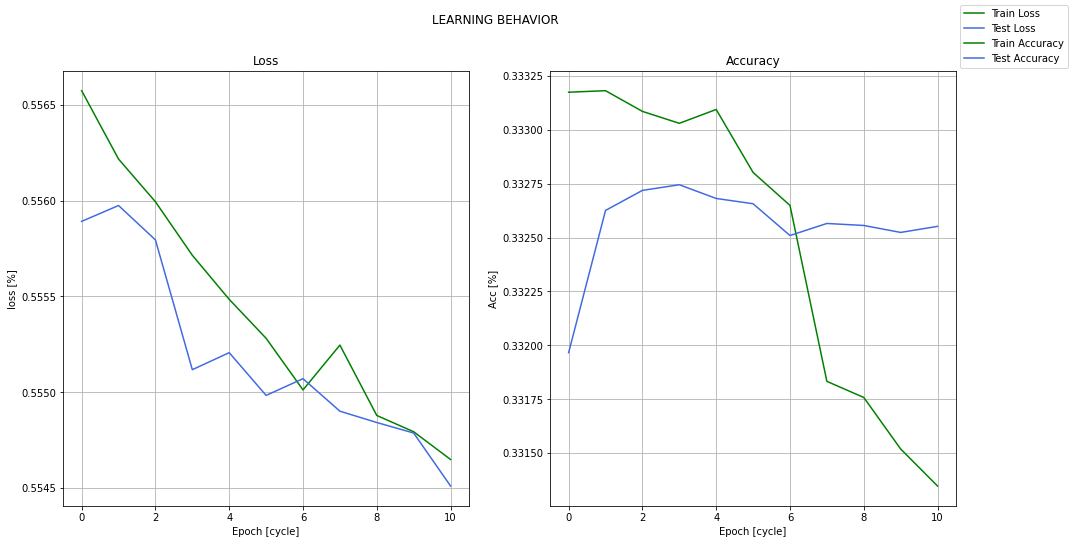

In [160]:
# reporting results
# reporte de entrenamiento para el modelo
# base de la figura
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# datos de la figura en de perdida y precision
ax1.plot(gen_history.history["loss"], 'green', label = "Train Loss")
ax1.plot(gen_history.history["val_loss"], 'royalblue', label = "Test Loss")
ax2.plot(gen_history.history["accuracy"], 'green', label = "Train Accuracy")
ax2.plot(gen_history.history["val_accuracy"], 'royalblue', label = "Test Accuracy")

# leyenda de la grafica
fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel = "Epoch [cycle]", ylabel = "loss [%]")
ax2.set(xlabel = "Epoch [cycle]", ylabel = "Acc [%]")
fig.legend()
fig.show()

In [161]:
# saving image in png file
imgext = "jpg"
work_learn_img = model_fname + "-" + str_date + "-" + work_sufix + "-learn-curve." + imgext
img_fpn = os.path.join(root_folder, dataf, reportf, work_learn_img)
print(os.path.exists(img_fpn))
print(img_fpn)

False
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Reports\vvg_text2img_gen-19-May-2021-Paintings-learn-curve.jpg


In [201]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)

In [206]:
test = gen_results[3]
test = test*255
test = np.asarray(test).astype("uint8")
print(test.shape)
# cv2.imshow("test", test)